---
title: Naive Langchain Rating
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.17.1
  kernelspec:
    display_name: nix
    language: python
    name: nix
---


Set the `cd` to the project root:

In [2]:
import os, subprocess

os.chdir(subprocess
         .check_output(["git", "rev-parse", "--show-toplevel"])
         .decode('utf-8')
         .strip())
os.getcwd()

#if not Repo("data").head.commit.hexsha == '5222be26ac04c2e2d498373a78372d6072faf080':
#    warnings.warn("Data repository not in the same state as when this notebook was written.")

'/home/kerry/mnt/counter/madrs-ai'

Defining the graph:

Invocation. The server here was started on the backend with something like
```sh
python -m llama_cpp.server \
    --model ./models/mistralai_Mistral-Small-3.1-24B-Instruct-2503-Q4_K_M.gguf \
    --model_alias mistral \
    --host 0.0.0.0 --port 8080 \
    --n_gpu_layers -1 \
    --n_ctx 50000 \
    --chat_format chatml-function-calling
```

In [3]:
from typing import Annotated, Optional
from langchain_core.language_models.chat_models import BaseChatModel
from langchain_core.prompts import PromptTemplate
from langchain_core.messages import HumanMessage
from langgraph.graph import END, START, MessagesState, StateGraph
from pydantic import BaseModel, Field

def build_rater(llm: BaseChatModel):

    MadrsFieldScore = Annotated[
        int,
        Field(
            description="The numerical score for this field.",
            ge=0,
            le=6,
        )
    ]
    class MadrsFieldRating(BaseModel):
        score: int = Field(
            description="The numerical score for this field.",
            ge=0,
            le=6,
        )
        justification: str = Field(
            description="A brief justification for the score given for this field."
        )

    class MadrsRating(BaseModel):
        apparent_sadness: MadrsFieldRating = Field(
            description = "The MADRS rating for apparent sadness."
        )
        reported_sadness: MadrsFieldRating = Field(
            description = "The MADRS rating for reported sadness."
        )
        inner_tension: MadrsFieldRating = Field(
            description = "The MADRS rating for inner tension."
        )
        reduced_sleep: MadrsFieldRating = Field(
            description = "The MADRSrating for reduced sleep."
        )
        reduced_appetite: MadrsFieldRating = Field(
            description = "The MADRS rating for reduced appetite."
        )
        concentration_difficulties: MadrsFieldRating = Field(
            description = "The MADRS rating for concentration difficulties."
        )
        lassitude: MadrsFieldRating = Field(
            description = "The MADRS rating for lassitude."
        )
        inability_to_feel: MadrsFieldRating = Field(
            description = "The MADRS rating for inability to feel."
        )
        pessimistic_thoughts: MadrsFieldRating = Field(
            description = "The MADRS rating for pessimistic thoughts."
        )
        suicidal_thoughts: MadrsFieldRating = Field(
            description = "The MADRS rating for suicidal thoughts."
        )

    class RaterState(MessagesState):
        transcript: str
        primer: str
        rating: Optional[MadrsRating]


    def build_prompt(state: RaterState):
        prompt_template = PromptTemplate.from_template(
            """
            You are an expert in psychiatric assessments and depression. For your
            recollection, consider the following primer on MADRS interviews:

            ---

            {primer}

            ---

            Using this information, provide the most accurate assessment of the
            following transcription of a MADRS interview. Provide your scores for
            each of the items described in the primer, providing a best guess for
            apparent sadness, together with a brief justification/discussion.

            ---

            {transcript}
            """
        )
        return {
            "messages": prompt_template.invoke(
                {
                    "transcript": state["transcript"],
                    "primer": state["primer"]
                }
            ).to_messages()
        }

    def invoke_llm(state: RaterState):
        return { "messages": llm.invoke(state["messages"]) }

    def invoke_structured_llm(state: RaterState):
        parse_message = HumanMessage("Please format your previous response in the prescibed way.")
        return {
            # Required to work with llama-cpp server, json_schema not supported yet
            "rating": llm.with_structured_output(MadrsRating, method="function_calling").invoke(
                state["messages"] + [parse_message]
            ),
        }

    return (
        StateGraph(RaterState)
        .add_node("build_prompt", build_prompt)
        .add_node("invoke_llm", invoke_llm)
        .add_node("invoke_structured_llm", invoke_structured_llm)
        .add_edge(START, "build_prompt")
        .add_edge("build_prompt", "invoke_llm")
        .add_edge("invoke_llm", "invoke_structured_llm")
        .add_edge("invoke_structured_llm", END)
        .compile()
    )

In [20]:
transcripts_paths

[PosixPath('data/interviews/transcripts/corrected/MAD-004.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-005.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-007.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-003.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-002.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-006.txt'),
 PosixPath('data/interviews/transcripts/corrected/MAD-001.txt')]

In [4]:
from langchain_openai import ChatOpenAI
from pathlib import Path

llm = ChatOpenAI(
    model = "mistral",
    base_url = "http://localhost:8080/v1",
    api_key = "NULL",
)
transcripts_path = Path("data/interviews/transcripts/corrected")
primer_path = Path("data/madrs-instructions/primer.md")
transcripts_paths = [transcripts_path / file for file in os.listdir("data/interviews/transcripts/corrected") if file.endswith("txt")]
graph = build_rater(llm)
with open(primer_path, "r") as file:
    primer = file.read()
results = {}
for transcript_path in transcripts_paths:
    with open(transcript_path) as file:
        transcript = file.read()
    response = graph.invoke({
        "transcript": transcript,
        "primer" : primer
    })
    results[transcript_path.name.rstrip(".txt")] = {
        "rating": response["rating"].model_dump(),
        "unstructured_rating": response["messages"][-1].content
    }


Push the output to a temp file.

In [5]:
import json

output_path = Path("temp/output.json")
with output_path.open(mode='w') as file:
    file.write(json.dumps(results, indent=3))

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

with open("data/interviews/ratings.json") as ratings_file:
    expert_ratings_df = pd.DataFrame.from_dict(json.load(ratings_file), orient = 'index').map(lambda x: x["score"])

with open("temp/output.json") as file:
    ai_ratings_dict = json.loads(file.read())

ai_ratings_dict = {key: value["rating"] for key, value in ai_ratings_dict.items()}
ratings_df = pd.DataFrame.from_dict(ai_ratings_dict, orient = "index").map(lambda x: x["score"])

In [17]:
ratings_df

,apparent_sadness,reported_sadness,inner_tension,reduced_sleep,reduced_appetite,concentration_difficulties,lassitude,inability_to_feel,pessimistic_thoughts,suicidal_thoughts
MAD-004,2,4,4,5,1,5,3,3,3,2
MAD-005,2,4,2,1,0,3,4,1,3,0
MAD-007,5,6,0,5,5,4,5,6,4,5
MAD-003,3,4,4,4,2,3,3,3,3,2
MAD-002,4,4,4,2,3,4,3,4,5,2
MAD-006,3,4,5,0,2,4,4,3,5,3
MAD-001,2,3,4,3,2,2,3,2,3,0


In [18]:
expert_ratings_df

,reported_sadness,apparent_sadness,inner_tension,reduced_sleep,reduced_appetite,concentration_difficulties,lassitude,inability_to_feel,pessimistic_thoughts,suicidal_thoughts
MAD-001,3,1,3,2,2,0,2,1,2,0
MAD-002,3,2,3,1,3,3,3,3,3,2
MAD-003,2,2,4,3,2,2,3,1,2,2
MAD-004,3,3,4,2,3,3,3,4,3,1
MAD-005,3,2,2,0,0,2,2,1,3,0
MAD-006,3,1,4,0,0,3,3,1,3,1
MAD-007,4,4,0,6,4,4,4,3,4,4
MAD-008,5,4,3,0,4,0,3,4,4,5
MAD-009,0,0,0,3,0,3,0,0,0,0
MAD-010,3,2,3,2,0,3,2,2,3,2


In [7]:
def plot_diff(patient):
    human_rating = expert_ratings_df.loc[patient]
    ai_rating = ratings_df.loc[patient]
    
    # make a plot 
    fig, ax = plt.subplots()
    # font sizes 
    plt.rc('axes', titlesize=22, labelsize=20)     
    plt.rc('xtick', labelsize=16)    
    plt.rc('ytick', labelsize=16)
    plt.rc('legend',fontsize=16) 
    # get spines out
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # make plot
    for i in human_rating.index: 
        plt.hlines(i, human_rating.loc[i], ai_rating.loc[i],zorder=0 )
    plt.scatter(human_rating, human_rating.index, color='lightblue', s=80,zorder=2, label='Human' )
    plt.scatter(ai_rating , ai_rating.index, color= 'white' ,s=60,zorder=1 ) # add this to hide the end of hline
    plt.scatter(ai_rating , ai_rating.index, color= 'None', edgecolors='darkblue', linewidth=2 ,s=80,zorder=3,label='Machine')
    
    # ticks etc 
    plt.yticks(human_rating.index)
    plt.xticks(range(7))
    plt.ylabel('MADRS Item')
    plt.xlabel('Score')
    plt.title(patient)
    plt.legend(bbox_to_anchor=(1.4, 1))
    plt.show();

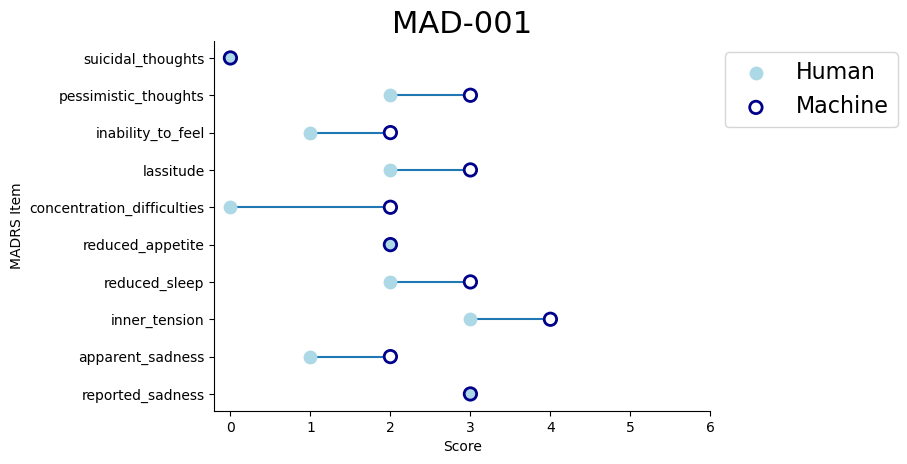

In [8]:
plot_diff("MAD-001")

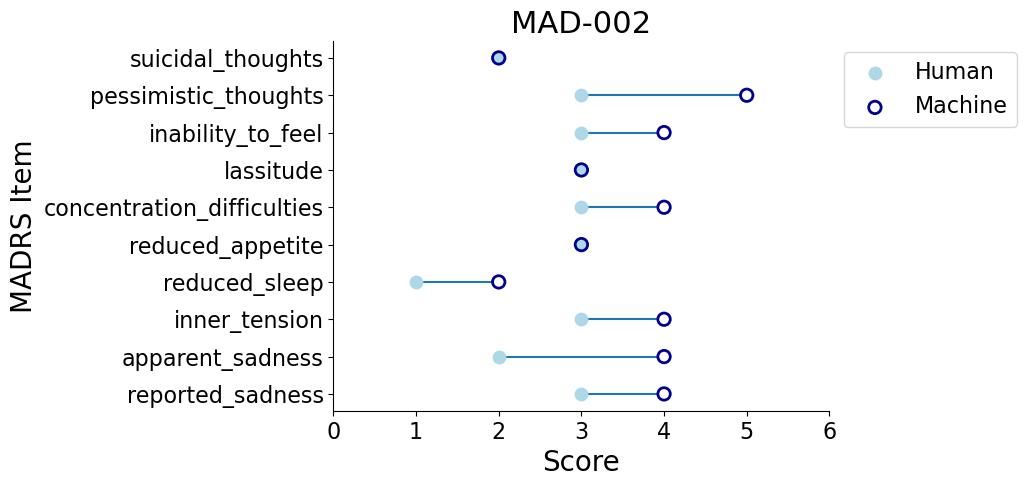

In [9]:
plot_diff("MAD-002")

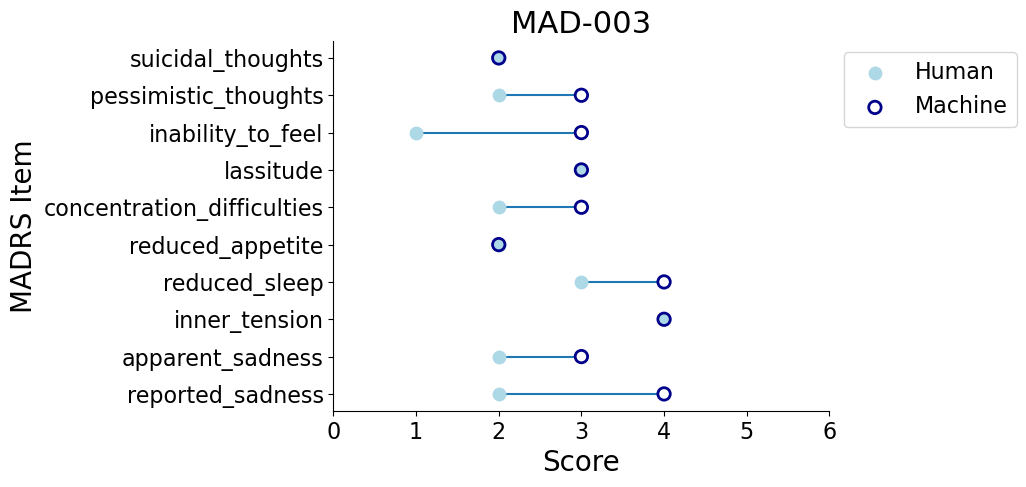

In [10]:
plot_diff("MAD-003")

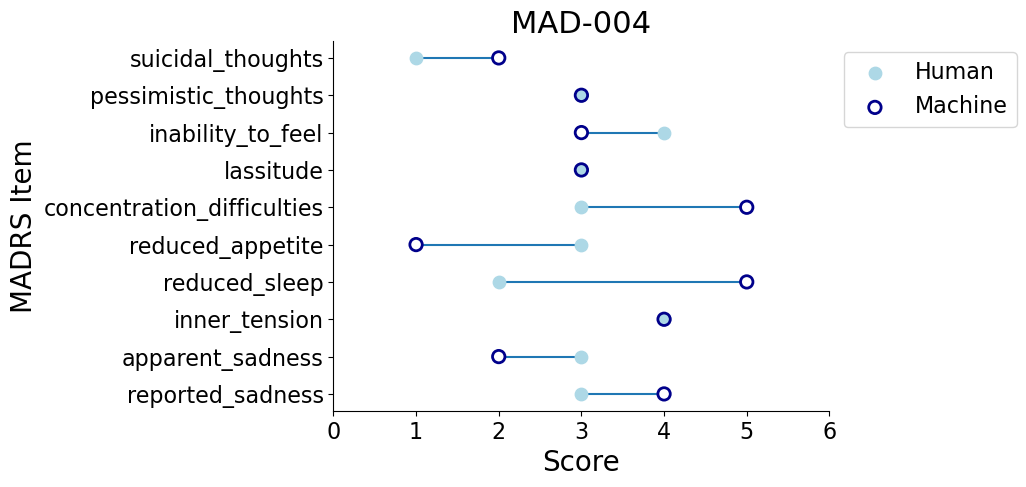

In [11]:
plot_diff("MAD-004")

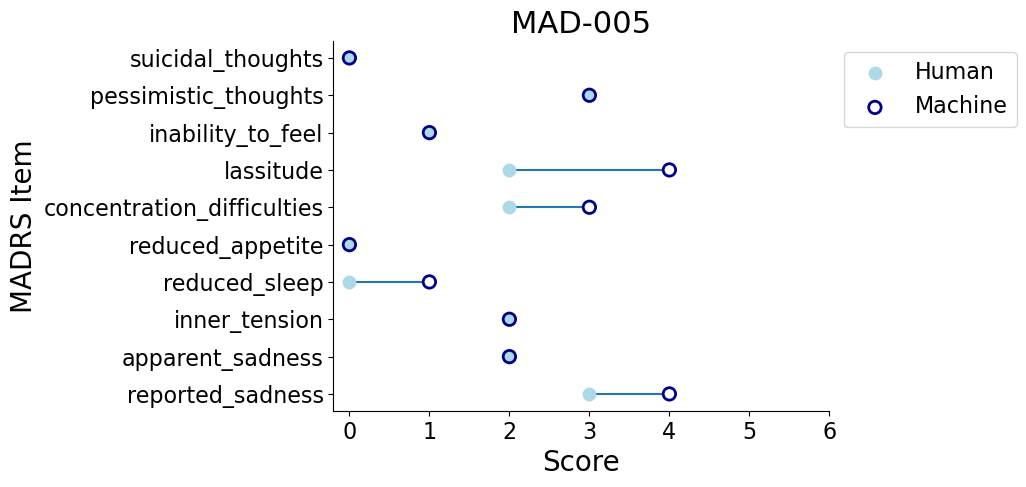

In [12]:
plot_diff("MAD-005")

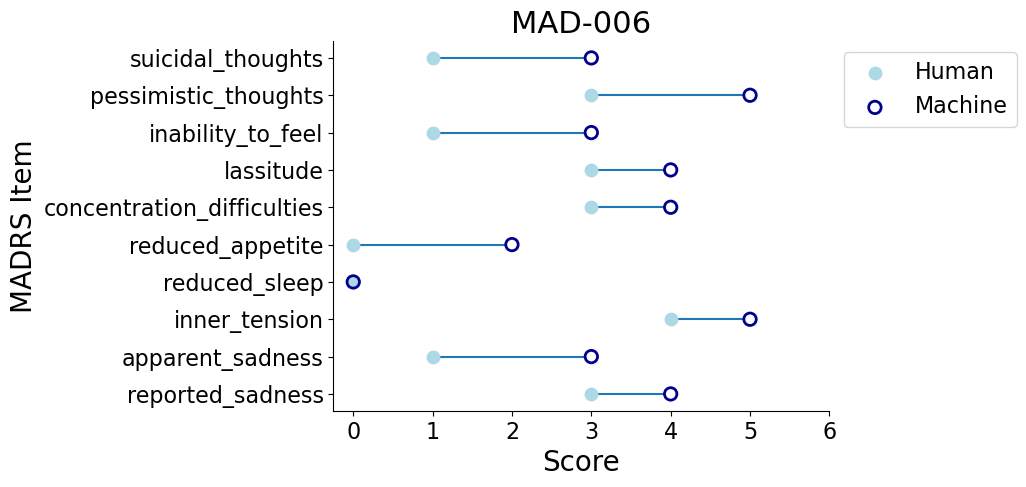

In [13]:
plot_diff("MAD-006")

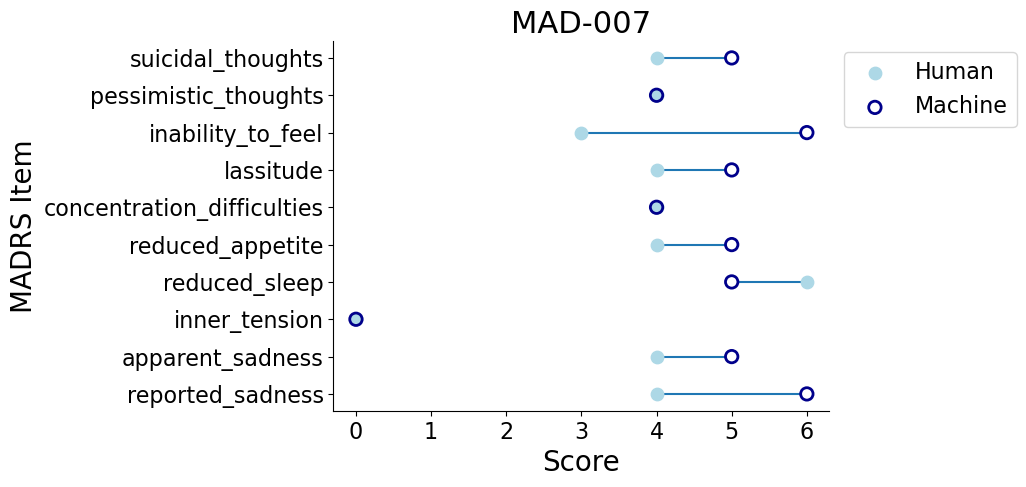

In [14]:
plot_diff("MAD-007")